# Anomaly Detection

## Gaussian Distribution

### Imports

In [1740]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

### Visualize Dataset

In [1741]:
data = loadmat('./ex8/ex8data1.mat')

In [1742]:
X = data['X']
Xval = data['Xval']
yval = data['yval']

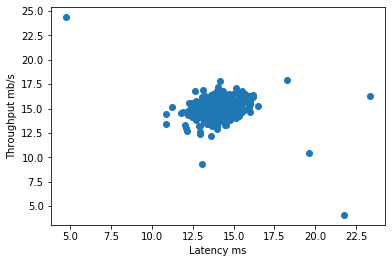

In [1743]:
plt.scatter(X[:, 0:1], X[:, 1:2]);
plt.ylabel('Throughput mb/s');
plt.xlabel('Latency ms');

## Estimating parameters for a Gaussian

In [1744]:
def estimate_gaussian_parameters(X):
    mu = np.average(X, axis = 0)
    variance = np.mean((X - mu)**2,axis=0)
    return mu, variance

In [1745]:
def gaussian_distribution(X, mu, sigma2):
    exp_term = -(X - mu) ** 2 / (2 * sigma2)
    exp_term = np.exp(exp_term)
    constant = np.sqrt(2 * np.pi * sigma2)
    constant = 1 / constant
    return constant * exp_term

In [1746]:
def covariance_matrix(X, mu):
    x = (X - mu) @ (X - mu).T
    return x / len(x)

In [1747]:
def multivariate_gaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    
    k = len(mu)
    sigma2=np.diag(sigma2)
    
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p


## Visualize Gaussian 

In [1748]:
mesh_values = np.linspace(0, 35, 70)

In [1749]:
mu, sigma2 = estimate_gaussian_parameters(X)

In [1750]:
X1, X2 = np.meshgrid(mesh_values, mesh_values)

In [1751]:
X_star = np.hstack((X1.reshape((-1,1)), X2.reshape((-1,1))))

In [1752]:
p_star = multivariate_gaussian(X_star, mu, sigma2)

(0, 27)

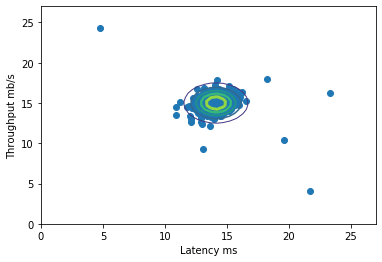

In [1753]:
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(X1, X2, p_star.reshape(X1.shape), 6, 
           linewidths=np.arange(.5, 4, .5))
plt.scatter(X[:, 0:1], X[:, 1:2]);
plt.ylabel('Throughput mb/s');
plt.xlabel('Latency ms');
plt.xlim([0, 27])
plt.ylim([0, 27])

## Selecting the threshold $\epsilon$

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. 

The low probability examples are more likely to be the anomalies in our dataset.

In [1754]:
def metrics(predictions, actual):
    tp = np.sum((predictions == True) & (actual == 1), 1)
    fp = np.sum((predictions == True) & (actual == 0), 1)
    tn = np.sum((predictions == False) & (actual == 0), 1)
    fn = np.sum((predictions == False) & (actual == 1), 1)
    return tp, fp, tn, fn

In [1755]:
def precision_metric(tp, fp):
    return tp / (tp + fp) 

In [1756]:
def recall_metric(tp, fn):
    return tp / (tp + fn)

In [1757]:
def f1_score(precision, recall):
    return (2* precision * recall) / (precision + recall)

In [1758]:
def select_threshold(yval, pval): 
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    best_epi = 0
    best_F1 = 0
    
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis]
        tp = np.sum(predictions[yval==1]==1)
        fp = np.sum(predictions[yval==0]==1)
        fn = np.sum(predictions[yval==1]==0)
        
        # compute precision, recall and F1
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        
        F1 = (2*prec*rec)/(prec+rec)
        
        if F1 > best_F1:
            best_F1 =F1
            best_epi = epi
        
    return best_epi, best_F1

## Anomalies

In [1759]:
p = multivariate_gaussian(X, mu, sigma2)
pval = multivariate_gaussian(Xval, mu, sigma2)
epsilon, F1 = select_threshold(yval, pval)
print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)

Best epsilon found using cross-validation: 8.990852779269496e-05
Best F1 on Cross Validation Set: 0.8750000000000001


/Users/aaron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [1760]:
anomaly_index = multivariate_gaussian(X, mu, sigma2) < epsilon
outliers = X[anomaly_index]

In [1761]:
mesh_values = np.linspace(0, 35, 70)

X1, X2 = np.meshgrid(mesh_values, mesh_values)

X_star = np.hstack((X1.reshape((-1,1)), X2.reshape((-1,1))))

contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)]).T

In [1762]:
p2 = multivariate_gaussian(X_star, mu, sigma2)

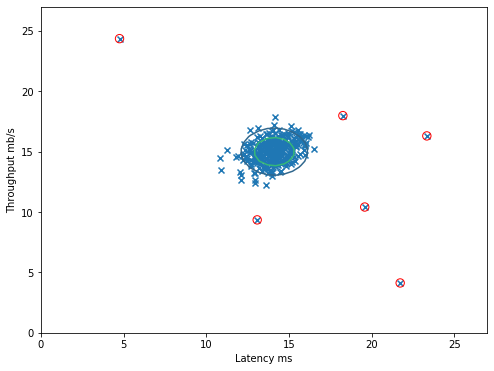

In [1763]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x")
plt.ylabel('Throughput mb/s');
plt.xlabel('Latency ms');
plt.xlim([0, 27])
plt.ylim([0, 27])
# plt.plot(outliers, 'ro', linewidth=2, markersize=5);

# plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(X1, X2, p2[:, None].reshape(X1.shape), 2)


# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker ="o",facecolor="none",edgecolor="r",s=70)

## High Dimensional Dataset

In [1764]:
data = loadmat('./ex8/ex8data2.mat')

In [1765]:
X = data['X']
Xval = data['Xval']
yval = data['yval']

In [1766]:
# compute the mean and variance
mu, sigma2 = estimate_gaussian_parameters(X)
# Training set
p = multivariate_gaussian(X, mu, sigma2)
# cross-validation set
pval = multivariate_gaussian(Xval, mu, sigma2)
# Find the best threshold
epsilon, F1 = select_threshold(yval, pval)

print("Best epsilon:",epsilon)
print('-----------------------------------')
print("Max F1:",F1)
print('-----------------------------------')
print("Outliers found:",np.sum(p < epsilon))

Best epsilon: 1.377228890761358e-18
-----------------------------------
Max F1: 0.6153846153846154
-----------------------------------
Outliers found: 117


/Users/aaron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


# Recommender Systems

### Imports

In [1767]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [1768]:
data = loadmat('./ex8/ex8_movies.mat');
params0 = loadmat('./ex8/ex8_movieParams.mat')

In [1769]:
X_params = params0['X']
Theta_params = params0['Theta']
num_users = params0['num_users']
num_movies = params0['num_movies']
num_features = params0['num_features']

In [1770]:
Y = data['Y']
R = data['R']

In [1771]:
print(f'Y (num movies x num users) Shape: {Y.shape}')
print(f'R (user j, rating i) Shape: {R.shape}')
print(f'Theta Shape: {Theta_params.shape}')
print(f'X_params Shape: {X_params.shape}')

Y (num movies x num users) Shape: (1682, 943)
R (user j, rating i) Shape: (1682, 943)
Theta Shape: (943, 10)
X_params Shape: (1682, 10)


In [1772]:
y_df = pd.DataFrame(Y)
r_df = pd.DataFrame(R)

From the matrix, we can compute statistics like average rating.

In [1773]:
avg_rating = y_df.iloc[0, r_df.iloc[0, :]].mean()
print(f'Average rating for movie 1 (Toy Story): {round(avg_rating, 2)}')

Average rating for movie 1 (Toy Story): 4.52


### Visualize

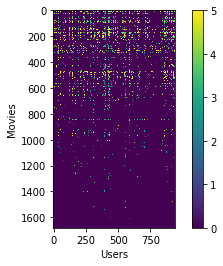

In [1774]:
plt.imshow(Y);
plt.ylabel('Movies');
plt.xlabel('Users');
plt.colorbar();

## Collaborative Filtering Learning Algorithm

### Collaborative Filtering Cost Function

In [1775]:
print(f'Num Users: {num_users.flatten()}')
print(f'Num Movies: {num_movies.flatten()}')
print(f'Num Features: {num_features.flatten()}')

Num Users: [943]
Num Movies: [1682]
Num Features: [10]


In [1776]:
num_users = 4
num_movies = 5
num_features = 3

### Collaborative filtering gradient

In [1777]:
def calculate_grads(Theta_params, X_params, Y, R):
    X_grad = ((Theta_params @ X_params.T - Y.T) * R.T).T @ Theta_params
    Theta_grad = ((Theta_params @ X_params.T - Y.T) * R.T) @ X_params
    return X_grad, Theta_grad

### Regularized cost function

In [1778]:
def regularized_cost(Theta_params, X_params, lmbda):
    x_term = np.sum(X_params ** 2)
    theta_term = np.sum(Theta_params ** 2)
    return (lmbda /2) * (theta_term + x_term)

### Regularized gradient

In [1779]:
def regularized_gradient(Theta_params, X_params, lmbda):
    dJdx_term = lmbda * X_params
    dJdTheta_term = lmbda * Theta_params
    return dJdx_term, dJdTheta_term

## Learning movie recommendations

### Recommendations

In [1780]:
movies = pd.read_csv('./ex8/movie_ids.csv', header = None).replace(to_replace = '\A\d', 
                                                                   value = '', regex = True)[0]

In [1781]:
my_ratings = np.zeros((Y.shape[0], 1))

### Set sample recommendations

In [1782]:
my_ratings[7] = 3;
my_ratings[12]= 5;
my_ratings[54] = 4;
my_ratings[64]= 5;
my_ratings[66]= 3;
my_ratings[69] = 5;
my_ratings[183] = 4;
my_ratings[226] = 5;
my_ratings[355]= 5;

In [1783]:
for rating in range(len(my_ratings)):
    if my_ratings[rating] > 0:
        print(f'Rated {my_ratings[rating][0]} for {movies[rating]}')

Rated 3.0 for  Babe (1995)
Rated 5.0 for 3 Mighty Aphrodite (1995)
Rated 4.0 for 5 Professional
Rated 5.0 for 5 What's Eating Gilbert Grape (1993)
Rated 3.0 for 7 Ace Ventura: Pet Detective (1994)
Rated 5.0 for 0 Four Weddings and a Funeral (1994)
Rated 4.0 for 84 Army of Darkness (1993)
Rated 5.0 for 27 Star Trek VI: The Undiscovered Country (1991)
Rated 5.0 for 56 Client


### Learning Movie Ratings

In [1784]:
r = np.zeros(my_ratings.shape)
r[my_ratings > 0] = 1

In [1785]:
Y = np.hstack((my_ratings, Y))
R = np.hstack((r, R))

In [1786]:
num_movies = Y.shape[0];
num_users = Y.shape[1];
num_features = 10

In [1787]:
X_rand = np.random.random((num_movies, num_features))
theta_rand = np.random.random((num_users, num_features))
params = np.concatenate((theta_rand.flatten(), X_rand.flatten()))


In [1788]:
def normalize(Y, R):
    Y = Y * R
    return Y - np.mean(Y, 0), np.mean(Y, 0)

In [1789]:
def cofiCostFunc(params, Y, R, lmbda, num_users, num_movies, num_features):
    
    # reshape the parameter array into parameter matrices

    theta_params = params[:num_users * num_features]  
    X_params = params[len(theta_params):].reshape((num_movies, num_features))
    Theta_params = theta_params.reshape((num_users, num_features))
    
    Y = Y[:num_movies, :num_users]
    R = R[:num_movies, :num_users]


    h = Theta_params @ X_params.T
    cost = h - Y.T
    cost = cost * R.T
    sq_cost = cost ** 2
    J = round(0.5 * np.sum(sq_cost), 2)
    
    # calculate the gradients
    X_grad = cost.T @ Theta_params
    Theta_grad = cost @ X_params
    
    x_term, theta_term = regularized_gradient(Theta_params, X_params, lmbda)
    
    X_grad += x_term
    Theta_grad += theta_term
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    reg_cost = regularized_cost(Theta_params, X_params, lmbda)
    
    
    return J + reg_cost, grad

In [1790]:
def costFunc(initial_parameters):
    # (Theta_params, X_params), Y, R, lmbda, num_users, num_movies, num_features
    return cofiCostFunc(initial_parameters, Y, R, 10, num_users, num_movies, num_features)

In [1791]:
Y, Ymean = normalize(Y, R)

In [1792]:
from scipy.optimize import minimize

In [1793]:
results = minimize(costFunc, x0=params, method="L-BFGS-B", jac=True)
theta = results["x"]

In [1794]:
Thetas = theta[:num_users * num_features].reshape((num_users, num_features))

In [1795]:
preds = (X_params @ Thetas.T) + Ymean

In [1796]:
pred_idxs = np.argsort(preds[:, 0])[::-1][:10]

### Model Evaluation

In [1798]:
for idx in pred_idxs:
    print(f'Predicted {round(preds[:, 0][idx], 1)} for movie: {movies[idx]}')

Predicted 3.3 for movie: 43 Sound of Music
Predicted 2.9 for movie: 75 Sense and Sensibility (1995)
Predicted 2.8 for movie: 85 My Fair Lady (1964)
Predicted 2.8 for movie: 19 Mary Poppins (1964)
Predicted 2.7 for movie: 96 It's a Wonderful Life (1946)
Predicted 2.7 for movie: 33 Gone with the Wind (1939)
Predicted 2.7 for movie: 13 Room with a View
Predicted 2.6 for movie: 40 Jane Eyre (1996)
Predicted 2.6 for movie: 24 Lost Highway (1997)
Predicted 2.6 for movie: 23 E.T. the Extra-Terrestrial (1982)
